# **Import** **Libraries**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation,performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


In [ ]:
#get the file
from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('/content/drive/MyDrive/Forecasting/Canada Airport Data.csv')
df.head()


Mounted at /content/drive


,Merged,Value
0,2022-01-01,"79,100"
1,2022-01-02,"72,224"
2,2022-01-03,"70,459"
3,2022-01-04,"64,980"
4,2022-01-05,"62,229"


In [ ]:
#check the last date
df.tail()

,Merged,Value
914,2024-07-03,"181,662"
915,2024-07-04,"177,131"
916,2024-07-05,"181,447"
917,2024-07-06,"178,767"
918,2024-07-07,"195,630"


**Data is from 01 Jan 2022 till 07 Jul 2024 and 919 rows**

In [ ]:
#check the columns
df.columns

Index(['Merged', 'Value'], dtype='object')

In [ ]:
#check data types
df.dtypes

Merged    object
Value     object
dtype: object

In [ ]:
def conversion(data):
  data['Merged'] = pd.to_datetime(data['Merged'])
  data['Value'] = data['Value'].str.replace(',','').astype(int)
  return data
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
df_converted=conversion(df)

In [ ]:
df_converted.rename(columns={"Merged": "Date"}).head()

,Date,Value
0,2022-01-01,79100
1,2022-01-02,72224
2,2022-01-03,70459
3,2022-01-04,64980
4,2022-01-05,62229


In [ ]:
df_converted.dtypes


Merged    datetime64[ns]
Value              int64
dtype: object

In [ ]:
# Exploratory data analysis
fig = px.line(df_converted, x='Merged', y='Value')
fig.update_xaxes(rangeslider_visible=True)
fig.show()



In [ ]:
df_converted.shape

(919, 2)

In [ ]:
#rename the columns because there is specific format prohpet takes and split the data.
df_converted.rename(columns={'Merged': 'ds', 'Value': 'y'}, inplace=True)
#split for train and test
split_date = '2024-01-01'
df_train = df_converted.loc[df_converted['ds'] <= split_date].copy()
df_test = df_converted.loc[df_converted['ds'] > split_date].copy()
# train_data = df_converted.sample(frac=0.8, random_state=10)
# validation_data = df_converted.drop(train_data.index)
print(f'training data size : {df_train.shape}')
print(f'validation data size : {df_test.shape}')
train_data = df_train.reset_index()
validation_data = df_test.reset_index()
train_data.head()

training data size : (731, 2)
validation data size : (188, 2)


,index,ds,y
0,0,2022-01-01,79100
1,1,2022-01-02,72224
2,2,2022-01-03,70459
3,3,2022-01-04,64980
4,4,2022-01-05,62229


In [ ]:
# Declare model instance and fit the training data
model = Prophet()
model.fit(train_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb_wr0z4k/uhcmn67b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb_wr0z4k/234wits3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38510', 'data', 'file=/tmp/tmpb_wr0z4k/uhcmn67b.json', 'init=/tmp/tmpb_wr0z4k/234wits3.json', 'output', 'file=/tmp/tmpb_wr0z4k/prophet_modelke_bouku/prophet_model-20240722151619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:16:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:16:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Predict for rest of the data
prediction = model.predict(pd.DataFrame({'ds':validation_data['ds']}))
prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2024-01-02,161403.147895,149969.502094,173208.527055
1,2024-01-03,157043.779166,145876.794914,168715.720812
2,2024-01-04,154153.329052,142989.346830,165040.669051
3,2024-01-05,154995.735715,144140.831631,165702.039573
4,2024-01-06,143951.228248,132034.478246,155605.536387


In [ ]:

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(validation_data['y'], prediction['yhat'])
mse = mean_squared_error(validation_data['y'], prediction['yhat'])
mape = mean_absolute_percentage_error(validation_data['y'], prediction['yhat'])
rmse = np.sqrt(mse)
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'Mean Absolute Percentage Error: {mape:.2f}')


Mean Absolute Error: 9488.10
Mean Squared Error: 144149145.98
Root Mean Squared Error: 12006.21
Mean Absolute Percentage Error: 6.48


In [ ]:
# get plots for actual vs predicted
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=validation_data['ds'], y = validation_data['y'], name="actual targets"),secondary_y=False,)
fig.add_trace(go.Scatter(x=validation_data['ds'], y = prediction['yhat'], name="predicted targets"),secondary_y=True,)
fig.update_layout(title_text="Actual vs Predicted Targets")
fig.update_xaxes(title_text="Timeline")
fig.update_yaxes(title_text="actual targets", secondary_y=False)
fig.update_yaxes(title_text="predicted targets", secondary_y=True)
fig.show()

In [ ]:
df = pd.DataFrame({'Actual': validation_data['y'], 'Predicted': prediction['yhat']})
df['Actual'] = df['Actual'].dropna().astype(int)
df['Predicted'] = df['Predicted'].dropna().astype(int)
df.to_csv('/content/drive/MyDrive/Forecasting/Prophet_forecast_accuracy_file.csv', index=False)

In [ ]:
# Calculate the forecast error
prediction['Forecast Error'] = validation_data['y'] - prediction['yhat']
# Calculate the Mean Forecast Error (MFE)
mfe = prediction['Forecast Error'].mean()
# Calculate the Mean of Actual Values
mean_actual = validation_data['y'].mean()
# Calculate the Forecast Bias Percentage
forecast_bias_percentage = (mfe / mean_actual) * 100
# Print the results
print(f'Mean Forecast Error (MFE):{mfe:.2f}')
print(f'Mean of Actual Values: {mean_actual:.2f}')
print(f'Forecast Bias Percentage:{forecast_bias_percentage:.2f}%')
# Interpretation
if forecast_bias_percentage > 0:
    print("The forecasts are biased towards underestimating the actual values.")
elif forecast_bias_percentage < 0:
    print("The forecasts are biased towards overestimating the actual values.")
else:
    print("The forecasts are unbiased on average.")

Mean Forecast Error (MFE):-3443.32
Mean of Actual Values: 150796.70
Forecast Bias Percentage:-2.28%
The forecasts are biased towards overestimating the actual values.


In [ ]:
df_validate = cross_validation(model, initial='400 days', period='60 days', horizon = '20 days')#period is how much we add on each iteration,horizon is how far it will forecast

INFO:prophet:Making 6 forecasts with cutoffs between 2023-02-15 00:00:00 and 2023-12-12 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb_wr0z4k/tmuzt47v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb_wr0z4k/bpnrdrkj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19369', 'data', 'file=/tmp/tmpb_wr0z4k/tmuzt47v.json', 'init=/tmp/tmpb_wr0z4k/bpnrdrkj.json', 'output', 'file=/tmp/tmpb_wr0z4k/prophet_modelk57qjv3w/prophet_model-20240722151621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:16:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:16:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb_wr0z4k/u2f8wp7n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb_wr0z4k/mt9ucu1o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [ ]:
df_validate.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-02-16,147466.801559,137342.434919,157290.867602,162149,2023-02-15
1,2023-02-17,144210.093690,133437.627750,154096.684946,148848,2023-02-15
2,2023-02-18,132601.790239,122316.781395,142021.678735,150905,2023-02-15
3,2023-02-19,138415.378479,128230.175801,148713.193637,149407,2023-02-15
4,2023-02-20,145556.193015,135105.916600,156026.729082,137212,2023-02-15


In [ ]:
df_performance_metric = performance_metrics(df_validate)
df_performance_metric.head(10)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,2 days,9.096743e+07,9537.684591,8180.312604,0.053136,0.044979,0.053481,0.750000
1,3 days,9.593274e+07,9794.526035,8468.453243,0.054597,0.044251,0.055413,0.833333
2,4 days,8.540124e+07,9241.279015,7684.543301,0.050746,0.041243,0.051004,0.750000
3,5 days,7.181519e+07,8474.384139,6901.892313,0.044717,0.041243,0.044579,0.750000
4,6 days,1.208214e+08,10991.879878,8576.627887,0.057041,0.050283,0.055814,0.666667
5,7 days,1.358465e+08,11655.320607,9485.057733,0.066000,0.056703,0.063427,0.583333
6,8 days,9.842750e+07,9921.063306,8032.156852,0.053068,0.039560,0.052281,0.666667
7,9 days,1.266127e+08,11252.229085,9773.276112,0.062027,0.062337,0.062029,0.583333
8,10 days,1.074746e+08,10366.994765,9527.296430,0.061113,0.059301,0.061075,0.666667
9,11 days,1.193105e+08,10922.935084,9687.395466,0.063543,0.045015,0.062490,0.666667


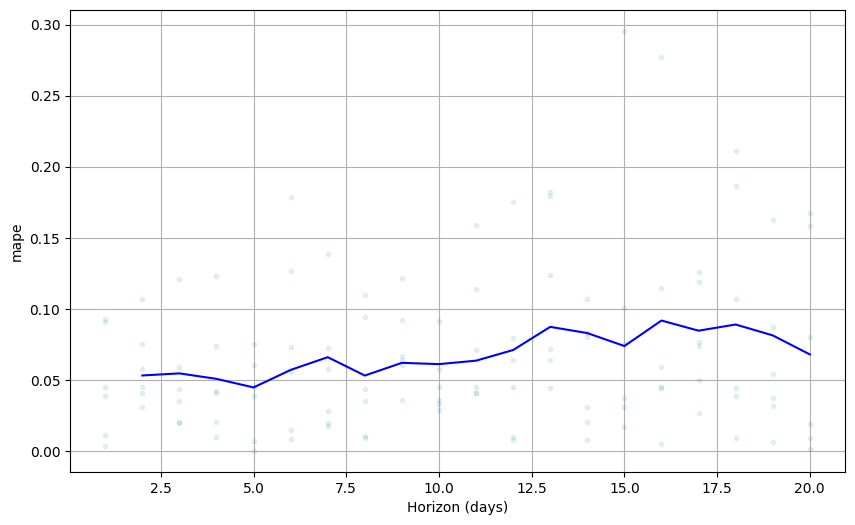

In [ ]:
figure = plot_cross_validation_metric(df_validate, metric='mape', color = 'b' ,point_color='darkcyan', figsize=(10, 6))


In [ ]:
# make prediction for next one year
future = model.make_future_dataframe(periods=365,include_history=False)
future.head(),future.tail()


(          ds
 0 2024-01-02
 1 2024-01-03
 2 2024-01-04
 3 2024-01-05
 4 2024-01-06,
             ds
 360 2024-12-27
 361 2024-12-28
 362 2024-12-29
 363 2024-12-30
 364 2024-12-31)

In [ ]:
#make future predictions
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2024-01-02,161403.147895,149506.437897,171901.548185
1,2024-01-03,157043.779166,145576.909499,168292.010741
2,2024-01-04,154153.329052,143231.577190,164818.596321
3,2024-01-05,154995.735715,144089.386027,166713.517239
4,2024-01-06,143951.228248,133234.414204,155093.121261


In [ ]:
#plot the results
plot_plotly(model, forecast)

In [ ]:
# Combine to get df
df_forecast=df_converted.merge(forecast[['ds', 'yhat']], on='ds', how='outer')
# df_forecast = pd.concat([df_converted, forecast[['ds', 'yhat']]], ignore_index=True)
fig = px.line(df_forecast, x='ds', y=['y', 'yhat'])
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [ ]:
df_forecast.tail()
print(df_forecast[df_forecast['ds']=='2024-02-03'])

            ds         y          yhat
763 2024-02-03  130684.0  127995.73157


In [ ]:
# Handle non-finite values before conversion
df_forecast['y'] = df_forecast['y'].dropna().astype(int)
#df_forecast['Predicted'] = df_validate['yhat'].dropna().astype(int)
df_forecast['yhat'] = df_forecast['yhat'].dropna().astype(int)
df_forecast=df_forecast.rename(columns={'ds': 'Dates','y': 'Actual','yhat': 'Forecast'})
df_forecast.head()
df_forecast.to_csv('/content/drive/MyDrive/Forecasting/Prophet_forecast_train_test.csv', index=False)



**Including holidays across Canada while forecasting**


In [ ]:
#define holidays df
holidays = make_holidays_df(year_list=[2022, 2023, 2024], country='CA')


In [ ]:
#include holiday parameter
m = Prophet(holidays=holidays)
m.fit(train_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb_wr0z4k/2w7vt9yl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb_wr0z4k/mt78zfae.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95700', 'data', 'file=/tmp/tmpb_wr0z4k/2w7vt9yl.json', 'init=/tmp/tmpb_wr0z4k/mt78zfae.json', 'output', 'file=/tmp/tmpb_wr0z4k/prophet_model55df83xe/prophet_model-20240722151624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:16:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:16:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


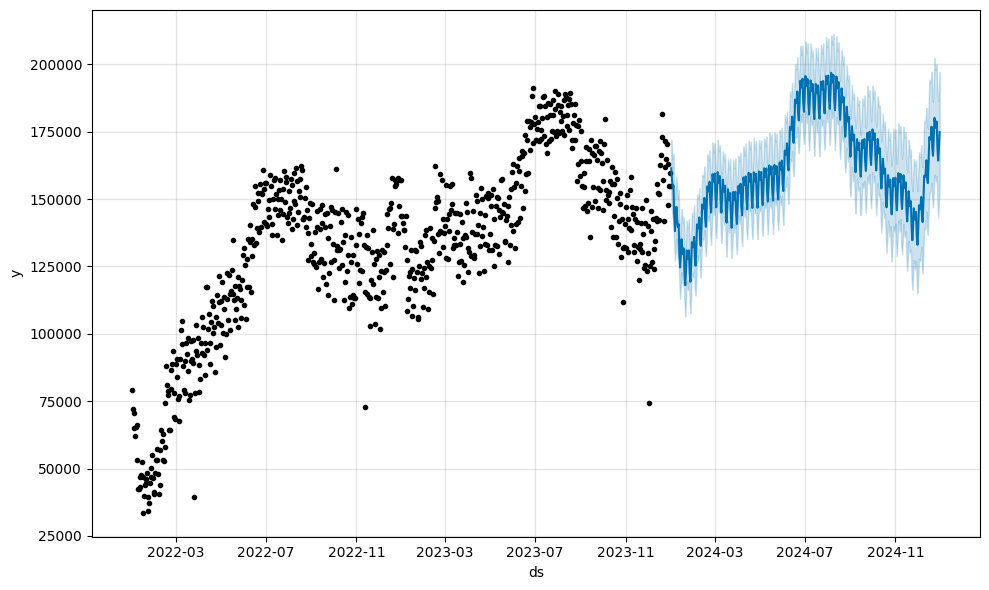

In [ ]:
future_h = m.make_future_dataframe(periods=365)
# Predict and plot the forecast
forecast_h = m.predict(future_h)
fig = m.plot(forecast)
fig.show()

In [ ]:
prediction_h = m.predict(pd.DataFrame({'ds':validation_data['ds']}))
prediction_h[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
183,2024-07-03,192834.924353,180672.002310,205533.135333
184,2024-07-04,191743.007518,179274.594065,204215.011588
185,2024-07-05,194439.589891,181433.674519,208341.389909
186,2024-07-06,185116.547288,172312.777092,198279.676022
187,2024-07-07,181057.998544,167144.796563,193535.345092


In [ ]:
#Calculating metrics
mae_h = mean_absolute_error(validation_data['y'], prediction_h['yhat'])
mse_h = mean_squared_error(validation_data['y'], prediction_h['yhat'])
mape_h = mean_absolute_percentage_error(validation_data['y'], prediction_h['yhat'])
rmse_h = np.sqrt(mse_h)
print(f'Mean Absolute Error: {mae_h:.2f}')
print(f'Mean Squared Error: {mse_h:.2f}')
print(f'Root Mean Squared Error: {rmse_h:.2f}')
print(f'Mean Absolute Percentage Error: {mape_h:.2f}%')

Mean Absolute Error: 9592.86
Mean Squared Error: 146000522.38
Root Mean Squared Error: 12083.07
Mean Absolute Percentage Error: 6.55%


In [ ]:
forecast_h = m.predict(future_h)
forecast_h[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1091,2024-12-27,176495.811165,155439.631915,196225.969191
1092,2024-12-28,166573.953967,146621.082752,186697.157550
1093,2024-12-29,161719.013726,140930.166746,182774.974415
1094,2024-12-30,166025.675479,145141.652949,185673.617572
1095,2024-12-31,172549.808079,150330.036721,191654.512054


In [ ]:
plot_plotly(m, forecast_h)

In [ ]:
df_forecast_h = pd.concat([df_converted, forecast_h[['ds', 'yhat']]], ignore_index=True)
fig = px.line(df_forecast_h, x='ds', y=['y', 'yhat'])
fig.update_xaxes(rangeslider_visible=True)
fig.show()

**Not significant difference in Mape after including holidays parameter**
Lets do cross-validation using built in functions from the library



In [ ]:
df_cv = cross_validation(m, initial='400 days', period='60 days', horizon = '30 days')

INFO:prophet:Making 6 forecasts with cutoffs between 2023-02-05 00:00:00 and 2023-12-02 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpb_wr0z4k/ek_fiq6s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb_wr0z4k/je5swudw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95963', 'data', 'file=/tmp/tmpb_wr0z4k/ek_fiq6s.json', 'init=/tmp/tmpb_wr0z4k/je5swudw.json', 'output', 'file=/tmp/tmpb_wr0z4k/prophet_modelvibqjvyu/prophet_model-20240722151932.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:19:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:19:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb_wr0z4k/dvpzy8vm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpb_wr0z4k/29p6clr0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [ ]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-02-06,131336.093875,122111.029876,140917.081348,109254,2023-02-05
1,2023-02-07,138916.867204,128597.379218,148191.866753,115611,2023-02-05
2,2023-02-08,130656.786402,120281.067867,139828.108514,125202,2023-02-05
3,2023-02-09,142455.879846,132798.852150,152645.023235,139355,2023-02-05
4,2023-02-10,139176.235594,129697.046851,148170.785898,124246,2023-02-05


In [ ]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,3.119316e+08,17661.585065,13572.663149,0.116233,0.079008,0.102813,0.500000
1,4 days,1.252095e+08,11189.703751,9597.743383,0.068373,0.056660,0.066057,0.666667
2,5 days,1.220988e+08,11049.831115,9523.469495,0.067314,0.049342,0.065151,0.611111
3,6 days,1.005584e+08,10027.881054,8726.909090,0.060641,0.046793,0.059313,0.722222
4,7 days,1.084572e+08,10414.279987,9100.613298,0.063391,0.053508,0.061668,0.666667


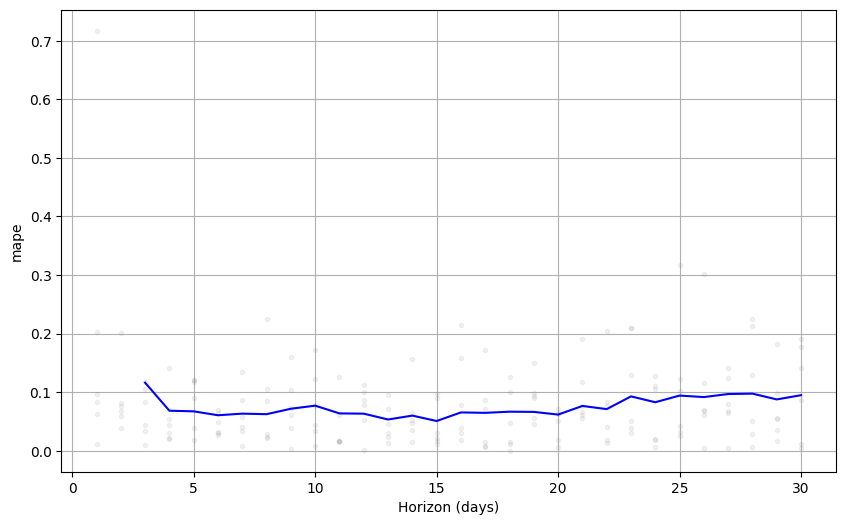

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='mape')


**Analysis**



* Both the MAE and RMSE are relatively large, indicating that the forecast errors are significant in absolute terms.
*   RMSE being larger than MAE is typical because RMSE penalizes larger errors more due to squaring the errors.


*   A MAPE of 5.57% is relatively low, suggesting that the forecasts are, on average, quite close to the actual values in percentage terms. This indicates a reasonably good model performance.
* Considerations  : Scale of the Data,The actual values are very large ( hundreds of thousands), an MAE of 7044.58 and an RMSE of 8575.27 can be considered relatively small.
* Accuracy : The very low forecast bias percentage (0.296%) indicates that the model is highly accurate in its predictions on average. The systematic error is almost negligible.

* Underestimation : Since the MFE is positive, it indicates a slight underestimation in the forecasts. However, given the small magnitude of the MFE relative to the mean of the actual values, this underestimation is minimal and likely not a cause for concern.
* Reliability: The model appears to be reliable, as it does not consistently overestimate or underestimate the actual values significantly.






